## Import Packages

In [1]:
import os
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.model_selection import train_test_split

In [2]:

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load data
with open('/content/alllines.txt', 'r') as f:
    doc = f.read()

In [ ]:
print(f'Length of text: {len(doc)} characters')

Length of text: 4583798 characters


In [ ]:
print(doc[:250])

"ACT I"
"SCENE I. London. The palace."
"Enter KING HENRY, LORD JOHN OF LANCASTER, the EARL of WESTMORELAND, SIR WALTER BLUNT, and others"
"So shaken as we are, so wan with care,"
"Find we a time for frighted peace to pant,"
"And breathe short-winded 


In [ ]:
# The unique characters in the file
vocab1 = sorted(set(doc))
print(f'{len(vocab1)} unique characters')

78 unique characters


## Text data Preprocessing

In [3]:
# Text preparation
def doc2words(doc):
    lines = doc.split('\n')
    lines = [line.strip(r'\"') for line in lines]
    words = ' '.join(lines).split()
    return words

def removepunct(words):
    punct = set(string.punctuation)
    words = [''.join([char for char in list(word) if char not in punct]) for word in words]
    return words

def getvocab(words):
    wordfreq = Counter(words)
    sorted_wordfreq = sorted(wordfreq, key=wordfreq.get)
    return sorted_wordfreq

def vocab_map(vocab):
    int_to_vocab = {k: w for k, w in enumerate(vocab)}
    vocab_to_int = {w: k for k, w in int_to_vocab.items()}
    return int_to_vocab, vocab_to_int

words = removepunct(doc2words(doc))
vocab = getvocab(words)
int_to_vocab, vocab_to_int = vocab_map(vocab)

## Dataset Processing

In [4]:
#Dataset preparation
class TextDataset(Dataset):
    def __init__(self, words, vocab_to_int, seq_size, batch_size):
        self.words = words
        self.vocab_to_int = vocab_to_int
        self.seq_size = seq_size
        self.batch_size = batch_size
        self.x_data, self.y_data = self.preprocess_data()

    def preprocess_data(self):
        word_ints = [self.vocab_to_int[word] for word in self.words]
        num_batches = int(len(word_ints) / (self.batch_size * self.seq_size))
        Xs = word_ints[:num_batches * self.batch_size * self.seq_size]
        Ys = np.zeros_like(Xs)
        Ys[:-1] = Xs[1:]
        Ys[-1] = Xs[0]
        Xs = np.reshape(Xs, (num_batches * self.batch_size, self.seq_size))
        Ys = np.reshape(Ys, (num_batches * self.batch_size, self.seq_size))
        return Xs, Ys

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]




## Define RNN

In [5]:
# Define RNN models
class RNNModule(nn.Module):
    def __init__(self, n_vocab, seq_size=32, embedding_size=64, lstm_size=128, num_layers=1, model_type='RNN', dropout=0.5):
        super(RNNModule, self).__init__()
        self.seq_size = seq_size
        self.lstm_size = lstm_size
        self.num_layers = num_layers
        self.model_type = model_type
        self.embedding = nn.Embedding(n_vocab, embedding_size)
        if model_type == 'LSTM':
            self.rnn = nn.LSTM(embedding_size, lstm_size, num_layers=num_layers, dropout=dropout, batch_first=True)
        elif model_type == 'GRU':
            self.rnn = nn.GRU(embedding_size, lstm_size, num_layers=num_layers, dropout=dropout, batch_first=True)
        else:
            self.rnn = nn.RNN(embedding_size, lstm_size, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.dense = nn.Linear(lstm_size, n_vocab)

    def forward(self, x, prev_state):
        embed = self.embedding(x)
        output, state = self.rnn(embed, prev_state)
        logits = self.dense(output)
        return logits, state

    def zero_state(self, batch_size):
        if self.model_type == 'LSTM':
            return (torch.zeros(self.num_layers, batch_size, self.lstm_size).to(device),
                    torch.zeros(self.num_layers, batch_size, self.lstm_size).to(device))
        else:
            return torch.zeros(self.num_layers, batch_size, self.lstm_size).to(device)







## Train and Evaluate Model

In [6]:

# Define training and evaluation functions
def get_loss_and_train_op(net, lr=0.001, weight_decay=1e-4):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
    return criterion, optimizer

def train_model(model, criterion, optimizer, trainloader, valloader, epochs=50, patience=5, clip=5):
    model = model.to(device)
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    best_model_path = 'best_model.pth'
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for x, y in trainloader:
            state = model.zero_state(x.size(0))
            if isinstance(state, tuple):
                state = (state[0].to(device), state[1].to(device))
            else:
                state = state.to(device)

            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            output, state = model(x, state)
            loss = criterion(output.transpose(1, 2), y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()

            if isinstance(state, tuple):
                state = (state[0].detach(), state[1].detach())
            else:
                state = state.detach()

            running_loss += loss.item()

        train_losses.append(running_loss / len(trainloader))
        val_loss, val_accuracy = evaluate_model(model, valloader, criterion)
        val_losses.append(val_loss)

        print(f'Epoch: {epoch + 1}, Training Loss: {train_losses[-1]:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            patience_counter = 0
            torch.save(best_model_state, best_model_path)
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping")
                break

    model.load_state_dict(torch.load(best_model_path))
    return model, train_losses, val_losses

def evaluate_model(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in dataloader:
            state = model.zero_state(x.size(0))
            if isinstance(state, tuple):
                state = (state[0].to(device), state[1].to(device))
            else:
                state = state.to(device)
            x, y = x.to(device), y.to(device)
            output, state = model(x, state)
            loss = criterion(output.transpose(1, 2), y)
            total_loss += loss.item()
            _, predicted = torch.max(output, 2)
            total += y.size(0) * y.size(1)
            correct += (predicted == y).sum().item()
    return total_loss / len(dataloader), correct / total

## Computing Perplexity

In [7]:
def compute_perplexity(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    total_words = 0
    with torch.no_grad():
        for x, y in dataloader:
            state = model.zero_state(x.size(0))
            if isinstance(state, tuple):
                state = (state[0].to(device), state[1].to(device))
            else:
                state = state.to(device)
            x, y = x.to(device), y.to(device)
            output, state = model(x, state)
            loss = criterion(output.transpose(1, 2), y)
            total_loss += loss.item() * y.size(0) * y.size(1)
            total_words += y.size(0) * y.size(1)
    perplexity = np.exp(total_loss / total_words)
    return perplexity



## Generate Text

In [8]:
# Generate text
def generate_text(device, net, words, n_vocab, vocab_to_int, int_to_vocab, top_k=5):
    net.eval()
    state = net.zero_state(1)
    if isinstance(state, tuple):
        state = (state[0].to(device), state[1].to(device))
    else:
        state = state.to(device)
    for w in words:
        ix = torch.tensor([[vocab_to_int[w]]]).to(device)
        output, state = net(ix, state)

    _, top_ix = torch.topk(output[0], k=top_k)
    choices = top_ix.tolist()
    choice = np.random.choice(choices[0])

    words.append(int_to_vocab[choice])

    for _ in range(100):
        ix = torch.tensor([[choice]]).to(device)
        output, state = net(ix, state)

        _, top_ix = torch.topk(output[0], k=top_k)
        choices = top_ix.tolist()
        choice = np.random.choice(choices[0])
        words.append(int_to_vocab[choice])

    print(' '.join(words))



## Testing Different Models - RNN, LSTM, GRU with different Architectures

Training LSTM model with batch_size=16, seq_size=32, embedding_size=64, lstm_size=128, num_layers=1
Epoch: 1, Training Loss: 6.8411, Validation Loss: 6.6249, Validation Accuracy: 0.0791
Epoch: 2, Training Loss: 6.6018, Validation Loss: 6.5675, Validation Accuracy: 0.0820
Epoch: 3, Training Loss: 6.5603, Validation Loss: 6.5331, Validation Accuracy: 0.0864
Epoch: 4, Training Loss: 6.5409, Validation Loss: 6.5173, Validation Accuracy: 0.0867
Epoch: 5, Training Loss: 6.5306, Validation Loss: 6.5166, Validation Accuracy: 0.0887
Epoch: 6, Training Loss: 6.5238, Validation Loss: 6.5017, Validation Accuracy: 0.0900
Epoch: 7, Training Loss: 6.5164, Validation Loss: 6.5039, Validation Accuracy: 0.0910
Epoch: 8, Training Loss: 6.5084, Validation Loss: 6.4987, Validation Accuracy: 0.0907
Epoch: 9, Training Loss: 6.5007, Validation Loss: 6.4880, Validation Accuracy: 0.0907
Epoch: 10, Training Loss: 6.4949, Validation Loss: 6.4825, Validation Accuracy: 0.0901
Epoch: 11, Training Loss: 6.4880, Valid

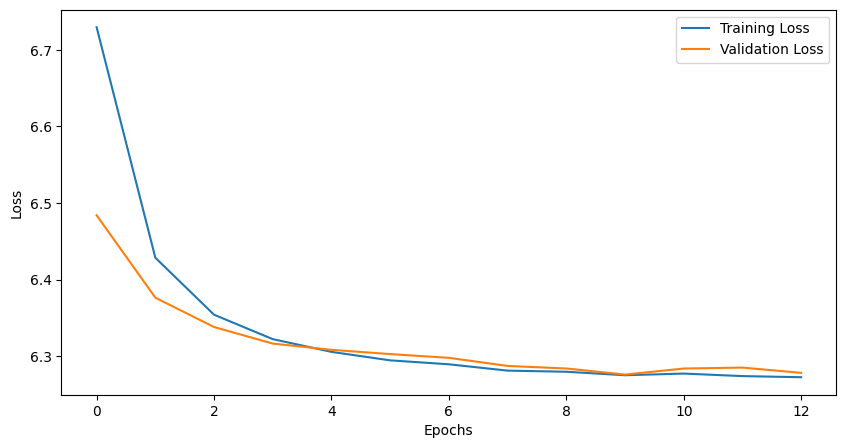

In [ ]:
# Parameters
batch_sizes = [16]
seq_sizes = [32]
embedding_sizes = [64, 128]
lstm_sizes = [128, 256]
num_layers_list = [1, 2, 3]


# Track the best model based on perplexity
best_model = None
best_perplexity = float('inf')

# Train and evaluate different models
for model_type in ['LSTM', 'GRU','RNN']:
    for batch_size in batch_sizes:
        for seq_size in seq_sizes:
            for embedding_size in embedding_sizes:
                for lstm_size in lstm_sizes:
                    for num_layers in num_layers_list:
                        print(f'Training {model_type} model with batch_size={batch_size}, seq_size={seq_size}, embedding_size={embedding_size}, lstm_size={lstm_size}, num_layers={num_layers}')

                        dataset = TextDataset(words, vocab_to_int, seq_size, batch_size)
                        train_size = int(0.8 * len(dataset))
                        val_size = len(dataset) - train_size
                        train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

                        trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
                        valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

                        model = RNNModule(len(vocab), seq_size, embedding_size, lstm_size, num_layers, model_type, dropout=0.5).to(device)
                        criterion, optimizer = get_loss_and_train_op(model, 0.01)
                        model, train_losses, val_losses = train_model(model, criterion, optimizer, trainloader, valloader, epochs=25, patience=3, clip=5)

                        perplexity = compute_perplexity(model, valloader, criterion)
                        print(f'{model_type} model perplexity: {perplexity:.4f}')

                        if perplexity < best_perplexity:
                            best_perplexity = perplexity
                            best_model = model
                            best_train_losses = train_losses
                            best_val_losses = val_losses

# Plot the training and validation loss of the best model
plt.figure(figsize=(10, 5))
plt.plot(best_train_losses, label='Training Loss')
plt.plot(best_val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


## Hyperparameter Tuning for Learning Rate, Drop out Rate and Weight Decay

In [ ]:
best_model

RNNModule(
  (embedding): Embedding(32641, 128)
  (rnn): GRU(128, 128, batch_first=True, dropout=0.5)
  (dense): Linear(in_features=128, out_features=32641, bias=True)
)

In [ ]:
import optuna

# Objective function for Optuna
def objective(trial):
    # Hyperparameters to tune
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 1e-1)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)
    dropout = trial.suggest_uniform('dropout', 0.2, 0.7)

    # Define model
    model = RNNModule(len(vocab), seq_size=32, embedding_size=128, lstm_size=128, num_layers=1, model_type='GRU', dropout=dropout).to(device)
    criterion, optimizer = get_loss_and_train_op(model, lr=learning_rate, weight_decay=weight_decay)

    # Train model
    _, train_losses, val_losses = train_model(model, criterion, optimizer, trainloader, valloader, epochs=50, patience=3, clip=5)

    # Calculate validation loss
    val_loss = val_losses[-1]

    return val_loss

# Create study and optimize
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Best hyperparameters
best_params = study.best_params
print("Best hyperparameters: ", best_params)

# Now you can use the best hyperparameters to train your final model
best_model = RNNModule(len(vocab), seq_size=32, embedding_size=128, lstm_size=128, num_layers=1, model_type='GRU', dropout=best_params['dropout']).to(device)
criterion, optimizer = get_loss_and_train_op(best_model, lr=best_params['learning_rate'], weight_decay=best_params['weight_decay'])
best_model, train_losses, val_losses = train_model(best_model, criterion, optimizer, trainloader, valloader, epochs=50, patience=3, clip=5)

# Plot the training and validation loss of the best model
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [18]:
best_model

RNNModule(
  (embedding): Embedding(32641, 128)
  (rnn): GRU(128, 128, batch_first=True, dropout=0.6)
  (dense): Linear(in_features=128, out_features=32641, bias=True)
)

In [19]:
# Generate text with the best model
generate_text(device, best_model, ['To', 'be'], len(vocab), vocab_to_int, int_to_vocab, top_k=5)

To be so much to you my liege And all your highness pleasure and you are not to my heart To see this ring and I do accuse your grace I have my lord to be a servant to my heart To give me leave to you with me And in your power and you must not have no power of your love And give you love for me For your own life I am no more than yours To have you both to hear you I do not so far To make a gentle daughter and your highness And to the gods
